In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from scipy import stats
from matplotlib.colors import TwoSlopeNorm
import regionmask
import pandas as pd
from matplotlib import colors
from cartopy.util import add_cyclic_point


In [2]:
def linear_trend(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return slope, p_value


# -------------------------------
# Helpers
# -------------------------------
def get_lat_lon(ds_like):
    for lon_name in ["lon", "longitude", "x"]:
        if lon_name in ds_like.coords:
            break
    else:
        raise ValueError("Longitude not found")
    for lat_name in ["lat", "latitude", "y"]:
        if lat_name in ds_like.coords:
            break
    else:
        raise ValueError("Latitude not found")
    return lat_name, lon_name

def to_cyclic(data2d, lon1d):
    return add_cyclic_point(np.asarray(data2d), coord=np.asarray(lon1d))

def symmetric_vlim(data):
    vmax = np.nanpercentile(np.abs(data), 98)
    return (-vmax, vmax)

def plot_panel(ax, data, pvals=None, title="", units="", vlim=None, cmap="RdBu_r",
               hatch="...", hatch_non_sig=False,
               lat_name="lat", lon_name="lon", lat=None, lon=None, pc=None):
    
    dat = np.asarray(data)
    if vlim is None:
        vlim = symmetric_vlim(dat)
    norm = TwoSlopeNorm(vcenter=0.0, vmin=vlim[0], vmax=vlim[1])

    # Convert to cyclic
    Z, lon_c = to_cyclic(data.transpose(lat_name, lon_name), lon)

    im = ax.pcolormesh(lon_c, lat, Z, cmap=cmap, norm=norm, transform=pc, shading="nearest")

    # Optional hatching for non-significant
    if (pvals is not None) and hatch_non_sig:
        P, _ = to_cyclic(pvals.transpose(lat_name, lon_name), lon)
        non_sig = np.where(P >= 0.10, 1.0, np.nan)
        ax.contourf(lon_c, lat, non_sig, levels=[0.5, 1.5], hatches=[hatch],
                    colors='none', transform=pc)

    ax.add_feature(cfeature.COASTLINE.with_scale("110m"), linewidth=0.5)
    ax.set_title(title, fontsize=11, pad=6)

    cb = plt.colorbar(im, ax=ax, orientation="horizontal", fraction=0.085, pad=0.04)
    cb.ax.set_xlabel(units, fontsize=9)
    cb.ax.tick_params(labelsize=8)

In [4]:
ds_pr = xr.open_dataset('../../../Data/Observations/ERA5/ERA5_mtpr_mer_1m_1979_2024.nc').mtpr.sel(latitude=slice(30,-30)).sel(valid_time=slice('1979','2024'))*86400
ds_t2m = xr.open_dataset('../../../Data/Observations/ERA5/ERA5_msl_t2m_skt_sst_1m_1979_2024.nc').sel(valid_time=slice('1979','2024')).sel(latitude=slice(30,-30)).t2m#-273.15
ds_evp = xr.open_dataset('../../../Data/Observations/ERA5/ERA5_mtpr_mer_1m_1979_2024.nc').mer.sel(latitude=slice(30,-30)).sel(valid_time=slice('1979','2024'))*86400

In [5]:
pr_yr = ds_pr.groupby('valid_time.year').mean()
t2m_yr = ds_t2m.groupby('valid_time.year').mean()
evp_yr = ds_evp.groupby('valid_time.year').mean()

In [6]:
Ts_clim = t2m_yr.mean('year')

In [7]:
L = 2268000
Rv = 461.5

In [8]:
alpha = (L/(Rv*(Ts_clim**2)))

In [ ]:
alpha

In [9]:
trend_slope_t2m , trend_pvalue_t2m  = xr.apply_ufunc(linear_trend,t2m_yr['year'], t2m_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

In [10]:
Ts_anom = t2m_yr - Ts_clim

In [11]:
P_minus_E_yr = (ds_pr+ds_evp).groupby('valid_time.year').mean()

In [12]:
P_minus_E_clim = P_minus_E_yr.mean('year')

In [13]:
mult = alpha*P_minus_E_clim

In [14]:
P_minus_E = mult*Ts_anom

In [15]:
trend_slope_EP , trend_pvalue_EP  = xr.apply_ufunc(linear_trend,P_minus_E['year'], P_minus_E,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

In [16]:
trend_slope_EP.to_netcdf('trend_slope_p_minus_e_reconstructed_using_cc.nc')
trend_pvalue_EP.to_netcdf('trend_pval_p_minus_e_reconstructed_using_cc.nc')

In [16]:
trend_slope_EP_org , trend_pvalue_EP_org  = xr.apply_ufunc(linear_trend,P_minus_E_yr['year'], P_minus_E_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

In [18]:
ds_w = xr.open_dataset('../../../Data/Observations/ERA5/ERA5_pressure_velocity_500hPa_1m_1979_2024.nc').sel(latitude=slice(30,-30)).sel(valid_time=slice('1979','2024')).w.squeeze()
ds_q = xr.open_dataset('../../../Data/Observations/ERA5/ERA5_q_RH_200_500_1000_hpa_1m_1979_2024.nc').sel(latitude=slice(30,-30)).sel(valid_time=slice('1979','2024')).sel(pressure_level=1000).q.squeeze()

In [19]:
ds_w = -ds_w
ds_q=ds_q

In [20]:
w_yr = ds_w.groupby('valid_time.year').mean()
q_yr = ds_q.groupby('valid_time.year').mean()

In [21]:
trend_slope_w , trend_pvalue_w  = xr.apply_ufunc(linear_trend,w_yr['year'], w_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

trend_slope_q , trend_pvalue_q  = xr.apply_ufunc(linear_trend,q_yr['year'], q_yr,
                       input_core_dims=[['year'], ['year']],
                       vectorize=True, dask='allowed',output_core_dims=[[], []])

In [22]:
w_m=ds_w.mean('valid_time')
q_m=ds_q.mean('valid_time')

In [23]:
dyn = q_m*trend_slope_w*(8816.32)
tdyn = w_m*trend_slope_q*(8816.32)

In [24]:
P_r = dyn+tdyn

C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)
C:\Users\li3n23\miniforge3\envs\work_CMIP\Lib\site-packages\cartopy\mpl\geoaxes.py:1655: UserWarning: linewidths is ignored by contourf
  result = super().contourf(*args, **kwargs)


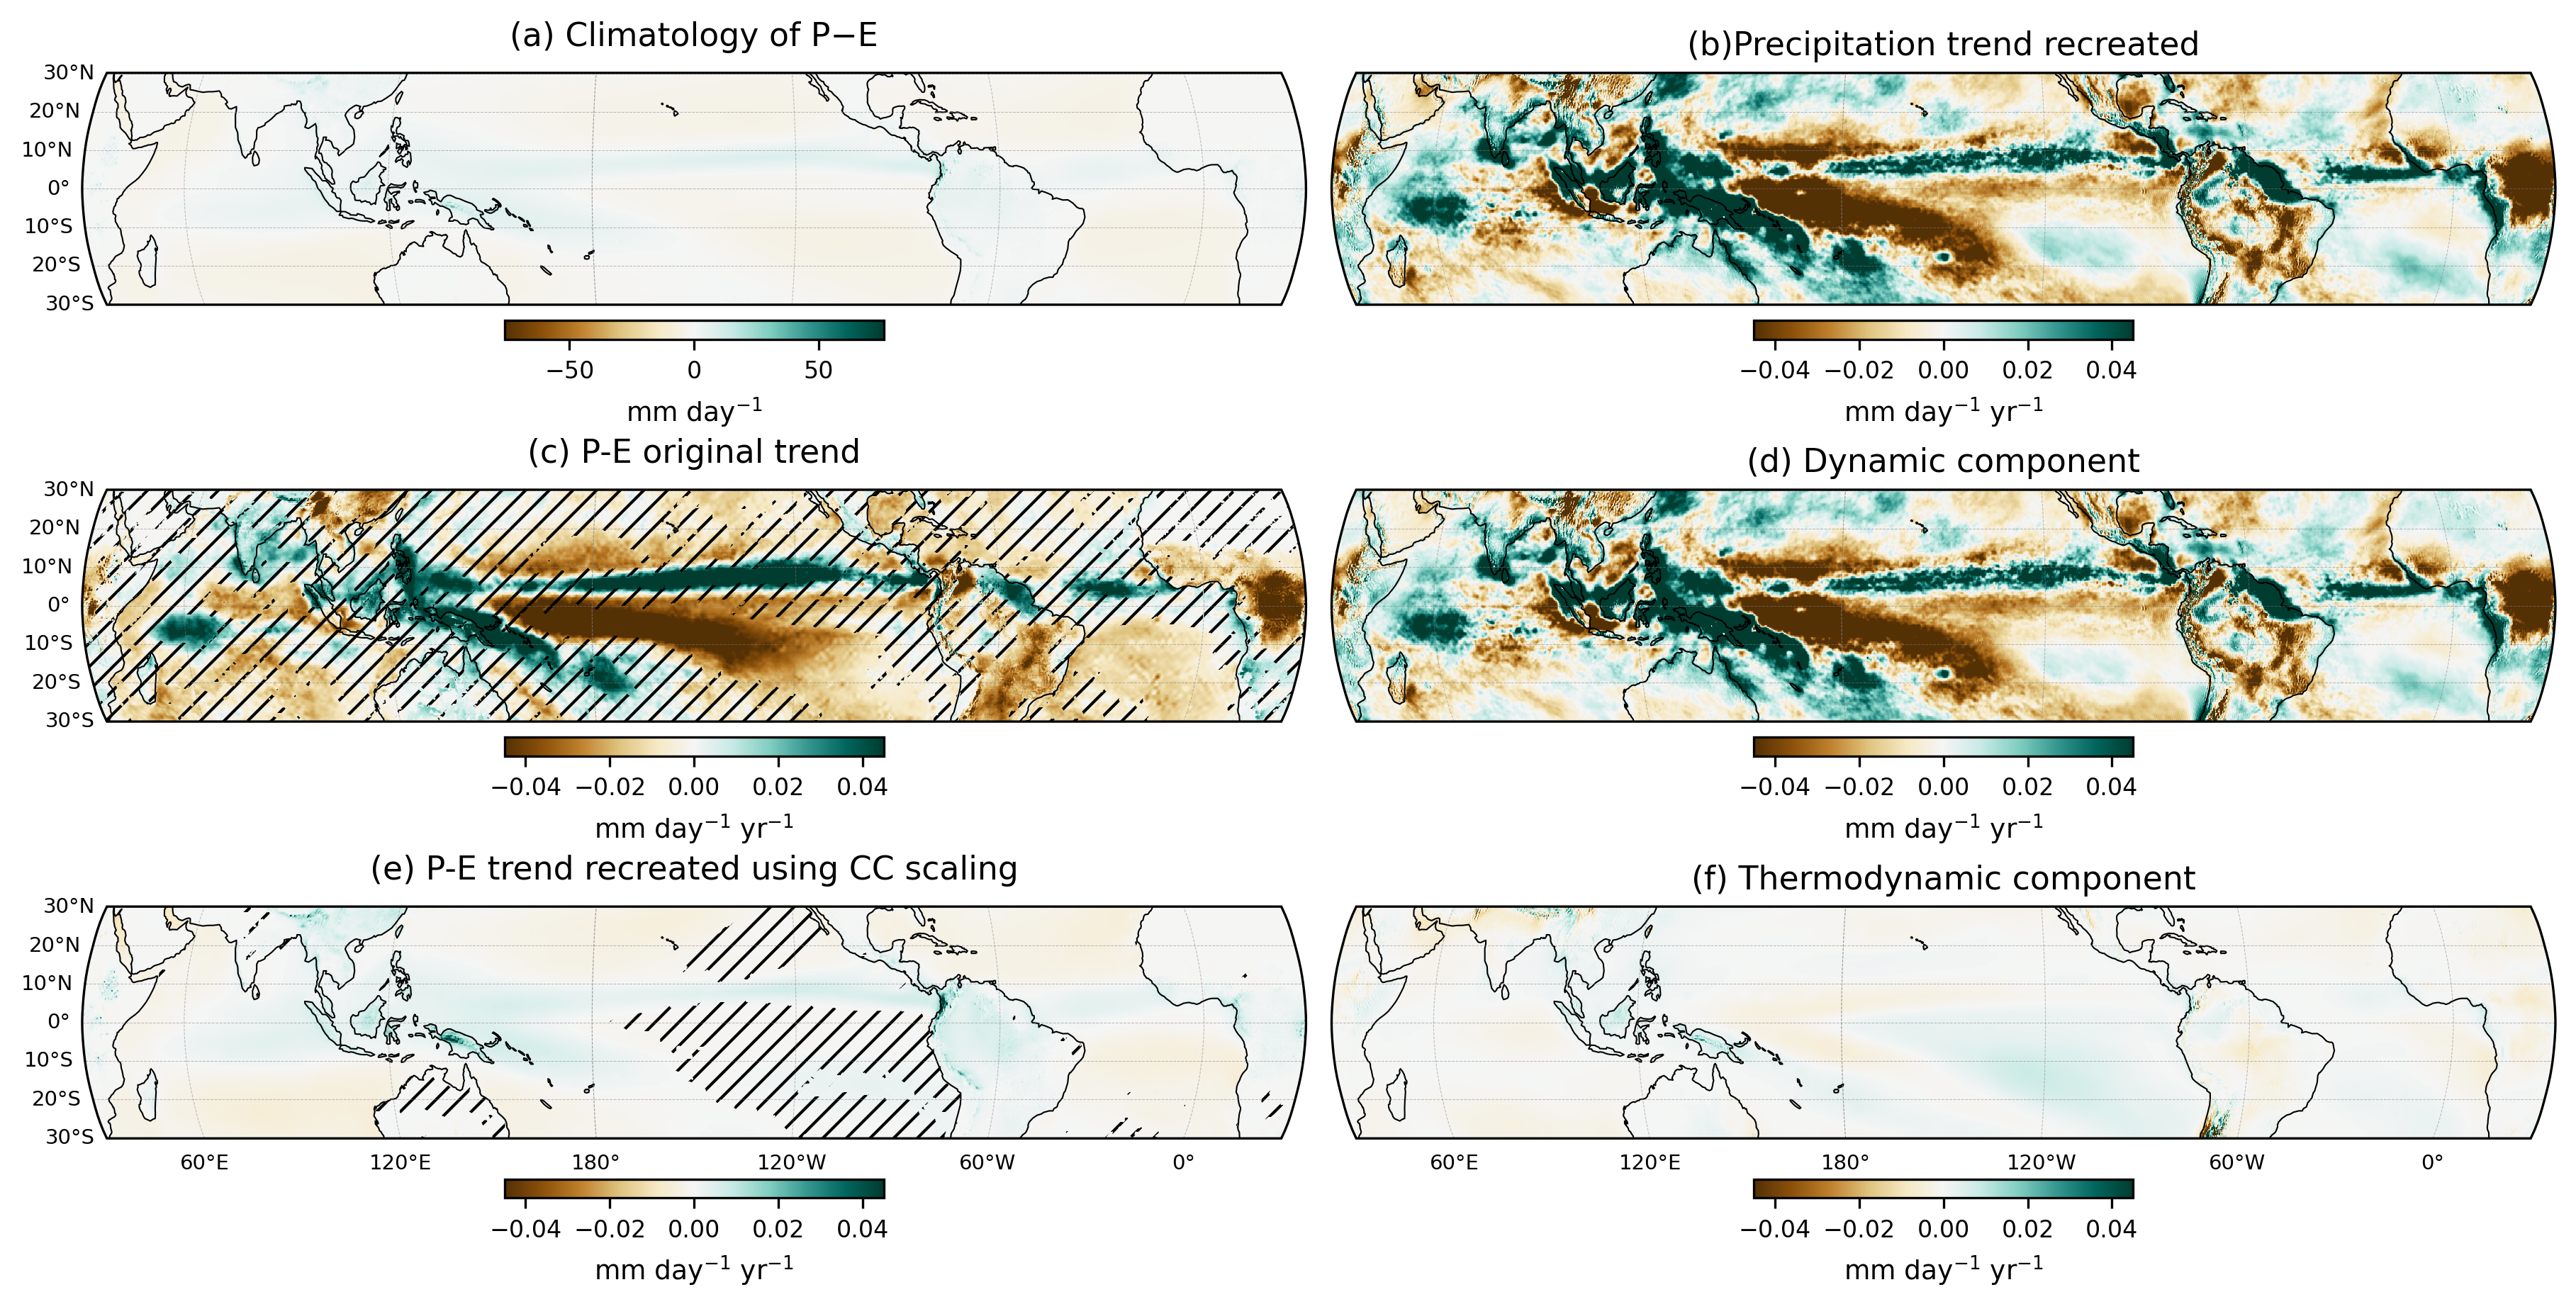

In [27]:
# -------------------------------
# Get coords & projection
# -------------------------------
lat_name, lon_name = get_lat_lon(P_minus_E_clim)
lat = P_minus_E_clim[lat_name]
lon = P_minus_E_clim[lon_name]

pc = ccrs.PlateCarree()
rob = ccrs.Robinson(central_longitude=210)

# -------------------------------
# Compute vlims
# -------------------------------
vlim_right = (-0.045,0.045)
vlim_left_trend = (-0.045,0.045)

# -------------------------------
# Plot layout
# -------------------------------
plt.rcParams.update({
    "font.size": 9,
    "font.family": "DejaVu Sans",
    "figure.dpi": 300,
})

fig, axes = plt.subplots(
    nrows=3, ncols=2,
    figsize=(12, 6),  # Shorter height for tropics
    subplot_kw={'projection': rob},
    constrained_layout=True
)

# -------------------------------
# Panel data & settings
# -------------------------------
panel_data = [
    # Row 1
    (P_minus_E_clim, None, "(a) Climatology of P−E", "mm day$^{-1}$", None),
    (P_r, None, "(b)Precipitation trend recreated", "mm day$^{-1}$ yr$^{-1}$", vlim_right),

    # Row 2
    (trend_slope_EP_org, trend_pvalue_EP_org, "(c) P-E original trend", "mm day$^{-1}$ yr$^{-1}$", vlim_left_trend),
    (dyn, None, "(d) Dynamic component", "mm day$^{-1}$ yr$^{-1}$", vlim_right),

    # Row 3
    (trend_slope_EP, trend_pvalue_EP, "(e) P-E trend recreated using CC scaling", "mm day$^{-1}$ yr$^{-1}$", vlim_left_trend),
    (tdyn, None, "(f) Thermodynamic component", "mm day$^{-1}$ yr$^{-1}$", vlim_right),
]

# -------------------------------
# Plot each panel
# -------------------------------
for idx, (data, pval, title, units, vlim) in enumerate(panel_data):
    row = idx // 2
    col = idx % 2
    hatch_flag = pval is not None and col == 0  # only left trend maps hatched

    plot_panel(
        ax=axes[row, col],
        data=data,
        pvals=pval,
        title=title,
        units=units,
        vlim=vlim,
        cmap="BrBG",
        hatch_non_sig=hatch_flag,
        lat_name=lat_name, lon_name=lon_name, lat=lat, lon=lon, pc=pc
    )

# -------------------------------
# Gridlines
# -------------------------------
for i in range(3):
    for j in range(2):
        gl = axes[i, j].gridlines(
            crs=pc, draw_labels=True, linewidth=0.25,
            color="0.5", alpha=0.5, linestyle="--"
        )
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 7}
        gl.ylabel_style = {"size": 7}

        gl.left_labels = (j == 0)
        gl.bottom_labels = (i == 2)

# -------------------------------
# Save and show
# -------------------------------
#plt.savefig("./Figures/Figure_2.png", dpi=600, bbox_inches="tight")
plt.show()
